Install Requirements

In [4]:
%pip install transformers torch tensorflow scikit-learn nltk networkx matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


Imports

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import ast
import matplotlib.pyplot as plt
import networkx as nx

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertModel
import torch

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand_xiu5rxo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load Dataset

In [6]:
df = pd.read_csv("all_job_post.csv")
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (1167, 5)


,job_id,category,job_title,job_description,job_skill_set
0,3902668440,HR,Sr Human Resource Generalist,SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXP...,"['employee relations', 'talent acquisition', '..."
1,3905823748,HR,Human Resources Manager,BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...,"['Talent Acquisition', 'Employee Performance M..."
2,3905854799,HR,Director of Human Resources,OUR CLIENT IS A THRIVING ORGANIZATION OFFERING...,"['Human Resources Management', 'Recruitment', ..."
3,3905834061,HR,Chief Human Resources Officer,JOB TITLE: CHIEF HUMAN RESOURCES OFFICER (CHRO...,"['talent management', 'organizational developm..."
4,3906250451,HR,Human Resources Generalist (Hybrid Role),DESCRIPTION\n\n WHO WE ARE \n\nAVI-SPL IS A DI...,"['Microsoft Office', 'Data analysis', 'Employe..."


Check Columns

In [7]:
print(df.columns)
print(df.shape)

Index(['job_id', 'category', 'job_title', 'job_description', 'job_skill_set'], dtype='object')
(1167, 5)


Text Cleaning Functions (NLP Part)

In [8]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text):
    words = text.split()
    filtered = [w for w in words if w not in stop_words]
    return " ".join(filtered)


Preprocess Dataset

In [9]:
df["job_description"] = df["job_description"].apply(clean_text).apply(remove_stopwords)

# Convert string list to python list
df["skills"] = df["job_skill_set"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

df[["job_title", "job_description", "skills"]].head()


,job_title,job_description,skills
0,Sr Human Resource Generalist,summary sr hr generalist provides hr expertise...,"[employee relations, talent acquisition, perfo..."
1,Human Resources Manager,part stellar team ysb manager human resources ...,"[Talent Acquisition, Employee Performance Mana..."
2,Director of Human Resources,client thriving organization offering unique o...,"[Human Resources Management, Recruitment, Empl..."
3,Chief Human Resources Officer,job title chief human resources officer chro i...,"[talent management, organizational development..."
4,Human Resources Generalist (Hybrid Role),description avi spl digital enablement solutio...,"[Microsoft Office, Data analysis, Employee onb..."


In [10]:
for cat in df["category"].unique():
    print(cat)

HR
INFORMATION-TECHNOLOGY
SALES
FINANCE
BUSINESS-DEVELOPMENT


In [11]:
pd.set_option("display.max_rows", None)

job_titles_df = pd.DataFrame(
    df["job_title"].unique(),
    columns=["Job Title"]
)

job_titles_df

,Job Title
0,Sr Human Resource Generalist
1,Human Resources Manager
2,Director of Human Resources
3,Chief Human Resources Officer
4,Human Resources Generalist (Hybrid Role)
5,Human Resources Generalist
6,Human Resources Information System Specialist
7,Human Resources Project Manager
8,Human Resources Information System Partner III
9,Human Resources Specialist


Prepare Input + Output (Tokenizer + MultiLabel)

In [12]:
texts = df["job_description"].tolist()
labels = df["skills"].tolist()

tokenizer_lstm = Tokenizer(num_words=10000)
tokenizer_lstm.fit_on_texts(texts)

sequences = tokenizer_lstm.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=150)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

print("Input shape:", X.shape)
print("Output labels shape:", y.shape)
print("Total unique skills:", len(mlb.classes_))


Input shape: (1167, 150)
Output labels shape: (1167, 5774)
Total unique skills: 5774


Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Build BiLSTM Model (LSTM Part)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

model = Sequential()
model.add(Input(shape=(150,)))   # 🔥 FIX
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dense(y.shape[1], activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5774)           │       744,846 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,140,174 (8.16 MB)

 Trainable params: 2,140,174 (8.16 MB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - auc: 0.5342 - loss: 0.5058 - val_auc: 0.6934 - val_loss: 0.0205
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - auc: 0.6964 - loss: 0.0199 - val_auc: 0.7403 - val_loss: 0.0203
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - auc: 0.7712 - loss: 0.0178 - val_auc: 0.7791 - val_loss: 0.0178
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - auc: 0.7991 - loss: 0.0161 - val_auc: 0.7882 - val_loss: 0.0172
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - auc: 0.7990 - loss: 0.0158 - val_auc: 0.7825 - val_loss: 0.0172
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - auc: 0.7929 - loss: 0.0158 - val_auc: 0.7811 - val_loss: 0.0172
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - auc: 0.7938 - loss: 0.0158 - val_auc: 0.7836 - val_loss: 0.0174
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - auc: 0.7943 - loss: 0.0158 - val_auc: 0.7820 - val_loss: 0.0174
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - au

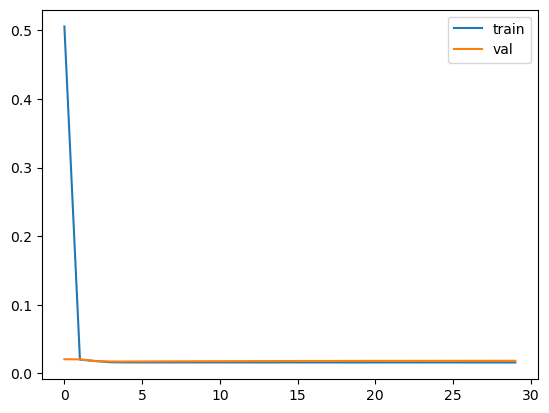

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

Accuracy and Loss 

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 1.82%
Test Accuracy: 78.37%


Load BERT

In [18]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BERT Embedding Function

In [19]:
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.numpy()


Test BERT Embedding

In [20]:
sample_text = df["job_description"].iloc[0]
emb = get_bert_embedding(sample_text)

print("BERT embedding shape:", emb.shape)


BERT embedding shape: (1, 768)


Skill Prediction Function

In [21]:
def predict_skills_bilstm(job_text, threshold=0.4):
    job_text = clean_text(job_text)
    job_text = remove_stopwords(job_text)

    seq = tokenizer_lstm.texts_to_sequences([job_text])
    X_input = pad_sequences(seq, maxlen=150)

    pred = model.predict(X_input)[0]

    predicted_skills = [mlb.classes_[i] for i, val in enumerate(pred) if val > threshold]

    return predicted_skills


For IT sector fields 

In [22]:
MASTER_SKILLS = {

    # Programming Languages
    "python","java","c","c++","c#","javascript","typescript","go","rust","scala","kotlin",
    "php","ruby","swift","r","matlab","perl","bash","powershell",

    # Web Development
    "html","css","react","angular","vue","next.js","node.js","express","django","flask",
    "spring","spring boot","laravel","asp.net","jquery","bootstrap","tailwind",

    # Databases
    "sql","mysql","postgresql","oracle","mongodb","redis","cassandra","dynamodb",
    "firebase","sqlite","neo4j","mariadb","elasticsearch",

    # Cloud Platforms
    "aws","azure","gcp","google cloud","amazon web services","microsoft azure",
    "ec2","s3","lambda","cloudformation","iam","rds","eks",
    "azure data factory","adf","azure devops","azure functions","blob storage",
    "bigquery","cloud run","cloud functions",

    # DevOps Tools
    "docker","kubernetes","terraform","ansible","jenkins","gitlab","github actions",
    "ci/cd","devops","helm","prometheus","grafana","nagios",

    # Data Engineering
    "etl","elt","data pipeline","data pipelines","airflow","apache airflow",
    "spark","pyspark","hadoop","hive","pig","kafka","databricks","snowflake",
    "redshift","synapse","delta lake",

    # Machine Learning / AI
    "machine learning","deep learning","nlp","computer vision","pytorch","tensorflow",
    "keras","scikit-learn","xgboost","opencv","huggingface","bert","llm",
    "langchain","rag","genai","generative ai",

    # Cybersecurity
    "cyber security","penetration testing","ethical hacking","network security",
    "cryptography","siem","splunk","firewall","ids","ips","vulnerability assessment",

    # Mobile Development
    "android","ios","flutter","react native","swiftui","kotlin android",

    # Testing / QA
    "selenium","cypress","junit","pytest","automation testing","manual testing",
    "testng","postman","api testing",

    # Tools / Version Control
    "git","github","bitbucket","jira","confluence","linux","unix","windows",
    "visual studio","vscode","intellij","eclipse",

    # Networking
    "tcp/ip","dns","http","https","vpn","routing","switching",

    # Analytics
    "power bi","tableau","excel","data analysis","data visualization","looker",

    # Others
    "microservices","rest api","graphql","soap","system design","distributed systems",
    "oop","data structures","algorithms"
}


In [23]:
def universal_skill_extractor(text):
    text = text.lower()

    found_skills = []
    for skill in MASTER_SKILLS:
        if skill in text:
            found_skills.append(skill)

    return sorted(list(set(found_skills)))


Skill extractor function

In [24]:
def final_skill_extractor(job_desc):
    bilstm_skills = predict_skills_bilstm(job_desc, threshold=0.4)
    rule_skills = universal_skill_extractor(job_desc)

    final_skills = list(set(bilstm_skills + rule_skills))
    return sorted(final_skills)


In [25]:
def build_knowledge_graph(job_role, skills):
    G = nx.Graph()
    G.add_node(job_role)

    for skill in skills:
        G.add_node(skill)
        G.add_edge(job_role, skill)

    return G


Build Knowledge Graph

In [26]:
def visualize_graph(G):
    plt.figure(figsize=(12,7))
    nx.draw(G, with_labels=True, node_size=2500, font_size=10)
    plt.show()


Test Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step

✅ Extracted Skills:
['azure', 'azure data factory', 'c', 'communication', 'data pipeline', 'data pipelines', 'databricks', 'etl', 'problem solving', 'python', 'r', 'spark', 'sql']


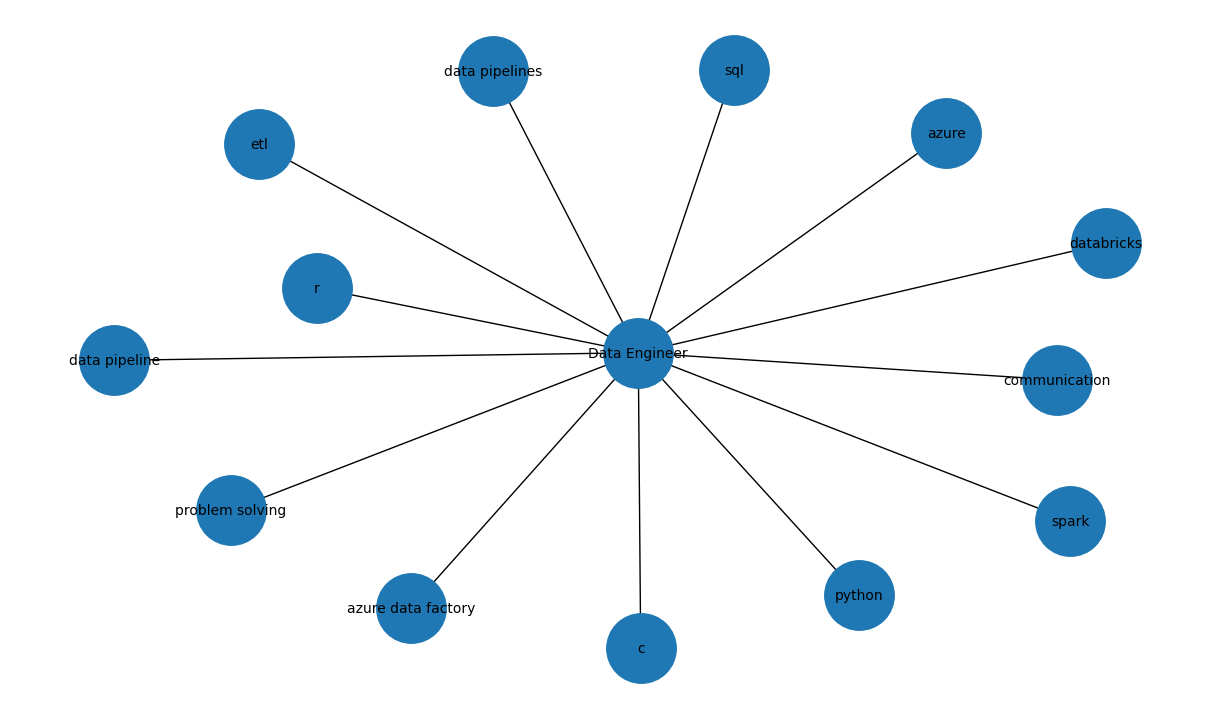

In [27]:
test_jd = """
Looking for a Data Engineer with strong Python, SQL, ETL, Azure Data Factory, Spark, Databricks and data pipelines experience.
"""

skills_found = final_skill_extractor(test_jd)

print("\n✅ Extracted Skills:")
print(skills_found)

G = build_knowledge_graph("Data Engineer", skills_found)
visualize_graph(G)


FINAL USER INPUT DEMO

Enter Job Role:  Sales Executive
Paste Job Description:  We are hiring a Sales Executive responsible for generating new leads, handling customer calls, and achieving monthly sales targets. The candidate should have excellent communication skills, negotiation skills, and experience in client relationship management. Responsibilities include preparing sales reports, meeting customers, and promoting company products. Knowledge of MS Excel, CRM tools, and basic sales strategy is preferred.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

✅ Extracted Skills:
['c', 'communication', 'excel', 'go', 'problem solving', 'r']

📌 Knowledge Graph Created!


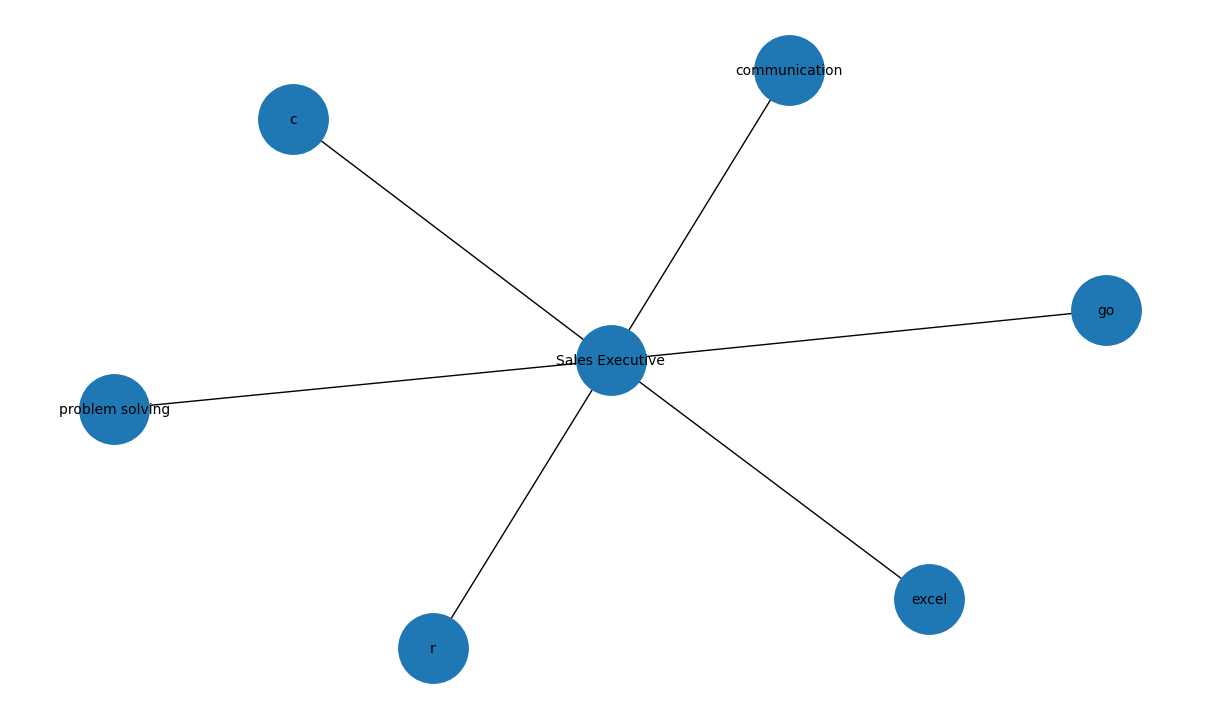

In [28]:
job_role = input("Enter Job Role: ")
job_desc = input("Paste Job Description: ")

skills_found = final_skill_extractor(job_desc)

print("\n✅ Extracted Skills:")
print(skills_found)

G = build_knowledge_graph(job_role, skills_found)

print("\n📌 Knowledge Graph Created!")
visualize_graph(G)


In [29]:
import pickle

# Save BiLSTM model
model.save("bilstm_skill_model.h5")

# Save tokenizer
with open("tokenizer_lstm.pkl", "wb") as f:
    pickle.dump(tokenizer_lstm, f)

# Save MultiLabelBinarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)

print("✅ Model + Tokenizer + MLB saved successfully!")


✅ Model + Tokenizer + MLB saved successfully!
